Connected to .venv (Python 3.11.5)

In [1]:
import pandas as pd
import os.path as op
import sys
import numpy as np
sys.path.append('./utils/')

import pymc as pm
import arviz as az
from pymc import do, observe
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

from nhanes_utils import pull_nhanes, merge_datasets

In [2]:
#TODO: add check if data is already loaded
download_data=False
outdir = './data/nhanes_data'

if download_data:
    
    year = 2015
    sub_dirs = ['Demographics', 'Questionnaire', 'Examination',]

    df_dems = pull_nhanes(year, outdir=outdir, sub_dirs=sub_dirs)

In [3]:
years = [2001, 2003, 2005, 2007, 2009, 2011, 2015, 2017]
year_endings = ['B', 'C', 'D', 'E', 'F', 'G', 'I', 'J']
data_files = [ 'AUQ_', 'AUX_', 'DEMO_']

#%
col_list = {2001: ['SEQN', 'RIDAGEYR', 'AUQ190', 'AUQ200', 'pta'],
            2003: ['SEQN', 'RIDAGEYR', 'AUQ190', 'AUQ200', 'pta'],
            2005: ['SEQN', 'RIDAGEYR', 'AUQ191', 'AUQ250', 'pta'], #no appropriate question for how often ringing 
            2007: ['SEQN', 'RIDAGEYR', 'AUQ191', 'AUQ250', 'pta'], #no appropriate question for how often ringing 
            2009: ['SEQN', 'RIDAGEYR', 'AUQ191', 'AUQ250', 'pta'], #no appropriate question for how often ringing 
            2011: ['SEQN', 'RIDAGEYR', 'AUQ191', 'AUQ255', 'pta'],
            2015: ['SEQN', 'RIDAGEYR', 'AUQ191', 'AUQ255', 'pta'],
            2017: ['SEQN', 'RIDAGEYR', 'AUQ191', 'AUQ255', 'pta']}


final_cmb = []

for year, ending in zip(years, year_endings):

    print(year)
    indir = op.join(outdir, str(year))
    cur_data_files = [cur_f + ending for cur_f in data_files]
    df = merge_datasets(indir=indir, data_files=cur_data_files)
    df['year'] = year

    cur_col_list = col_list[year]
    cur_col_list.append('year')

    replace_bads = lambda x: x.replace(to_replace={444: np.nan,
                                                   666: np.nan,
                                                   888: np.nan,})

    #500, 1000, 2000, and 4000 Hz -> PTA-4
    if 'AUXU1K2R' in df.columns: 
        df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
        df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
                                                                                   666: np.nan,
                                                                                   888: np.nan,}), axis=1)
    else:
        df['AUXU1KR'] = df['AUXU1K1R']
        df['AUXU1KL'] = df['AUXU1K1L']

    right_list = ['AUXU500R', 'AUXU1KR', 'AUXU2KR', 'AUXU4KR']
    left_list = ['AUXU500L', 'AUXU1KL', 'AUXU2KL', 'AUXU4KL',]


    df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
                                                                        666: np.nan,
                                                                        888: np.nan,}), axis=1),
                          np.nanmean(df[left_list].replace(to_replace={444: np.nan,
                                                                       666: np.nan,
                                                                       888: np.nan,}), axis=1)]), axis=0)
    cur_df = df[cur_col_list]
    #TODO: ask lisa how she recoded the variables
    cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
                                                                     2: False,
                                                                     9: np.nan})

    cur_df.dropna(subset=['pta','tinnitus'], inplace=True)
    cur_df['tinnitus'] = cur_df['tinnitus'] == True
    
    final_columns = ['RIDAGEYR', 'pta', 'tinnitus', 'year']
    tinn_dur = cur_col_list[3]
    if year in [2005, 2007, 2009]:
        df_f = cur_df.query('tinnitus == False')[final_columns]
    else:
        df_f = pd.concat([cur_df.query(f'{tinn_dur} == 1'), cur_df.query('tinnitus == False')])[final_columns]
    df_f.columns = ['age', 'pta', 'tinnitus', 'year']
    final_cmb.append(df_f)

2001


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2003


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2005


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2007


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2009


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2011


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2015


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

2017


<ipython-input-3-d2372c1e5743>:36: RuntimeWarning: Mean of empty slice
  df['AUXU1KR'] = np.nanmean(replace_bads(df[['AUXU1K1R','AUXU1K2R']]), axis=1)
<ipython-input-3-d2372c1e5743>:37: RuntimeWarning: Mean of empty slice
  df['AUXU1KL'] = np.nanmean(df[['AUXU1K1L','AUXU1K2L']].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:48: RuntimeWarning: Mean of empty slice
  df['pta'] = np.mean(([np.nanmean(df[right_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(df[left_list].replace(to_replace={444: np.nan,
<ipython-input-3-d2372c1e5743>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['tinnitus'] = cur_df[cur_col_list[2]].replace(to_replace={1: True,
<ipy

In [4]:
df_cmb = pd.concat(final_cmb).query('age < 75')

In [7]:
with pm.Model() as mediation_model:

    # intercept priors
    im = pm.Normal("im", 0, 1)
    iy = pm.Normal("iy", 0, 1)
    # slope priors
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1)
    cprime = pm.Normal("cprime", 0, 1)
    sigma = pm.Exponential('sigma', 1)

    m = pm.Normal('m', 
                mu=im + (a * sp.zscore(df_cmb['age'])),
                sigma=sigma,
                observed=sp.zscore(df_cmb['pta']))

    y = pm.Bernoulli('y', 
                 p=pm.invlogit(iy + (b * sp.zscore(df_cmb['pta'])) + cprime * sp.zscore(df_cmb['age'])),
                 observed=df_cmb['tinnitus'])

    indirect_effect = pm.Deterministic("indirect effect", a * b)
    total_effect = pm.Deterministic("total effect", a * b + cprime)

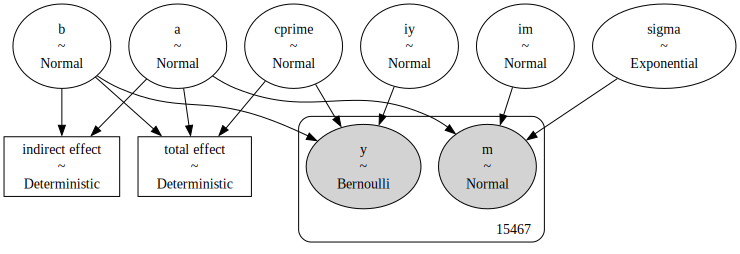

In [8]:
pm.model_to_graphviz(mediation_model)

In [9]:
sample_kwargs = {'draws': 4000,
                 'tune': 2000,
                 'chains': 4,
                 'target_accept': 0.9,}

with mediation_model:
    trace = pm.sample(**sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [im, iy, a, b, cprime, sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 297 seconds.


In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
im,0.000,0.006,-0.012,0.012,0.000,0.0,23290.0,11508.0,1.0
iy,-3.866,0.064,-3.985,-3.746,0.001,0.0,14124.0,11665.0,1.0
a,0.597,0.006,0.585,0.609,0.000,0.0,21811.0,11401.0,1.0
b,0.490,0.035,0.424,0.555,0.000,0.0,16965.0,12113.0,1.0
cprime,0.668,0.057,0.563,0.777,0.000,0.0,13210.0,12481.0,1.0
sigma,0.802,0.005,0.793,0.810,0.000,0.0,20270.0,11944.0,1.0
indirect effect,0.293,0.021,0.253,0.332,0.000,0.0,17044.0,12279.0,1.0
total effect,0.960,0.050,0.866,1.056,0.000,0.0,13670.0,13251.0,1.0


Nice! So The direct effect of age on tinnitus (cprime) is stronger then the indirect effect over hearing ability.
this kind of bolsters our claim that age is an independent risk factor for tinnitus. However, maybe keep in mind that while the audiogram is currently still the gold-standard to measure hearing ability "hidden" hearing loss exists and could explain these results.